In [1]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

Download the dataset Use TensorFlow Datasets to load the [Portuguese-English translation dataset](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en)D Talks Open Translation Project.<br>
This dataset contains approximately 52,000 training, 1,200 validation and 1,800 test examples. ```

In [2]:
examples, metadata = tfds.load('ted_hrlr_translate/ru_to_en', with_info=True, as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

Metal device set to: Apple M1 Pro


2022-10-12 22:32:33.700553: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-12 22:32:33.700758: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


The object returned by TensorFlow Datasets yields pairs of text examples:

In [3]:
for ru_examples, en_examples in train_examples.batch(3).take(1):
    print('> Examples in Russian:')
for ru in ru_examples.numpy():
    print(ru.decode('utf-8'))
    print()
    print('> Examples in English:')
for en in en_examples.numpy():
    print(en.decode('utf-8'))

> Examples in Russian:
к : успех , перемены возможны только с оружием в руках .

> Examples in English:
документация и методика практического обучения также доступна и выпущена creative commons .

> Examples in English:
( видео ) диди пиклз : сейчас четыре часа утра .

> Examples in English:
c : success , the change is only coming through the barrel of the gun .
the documentation and the hands-on teaching methodology is also open-source and released as the creative commons .
( video ) didi pickles : it 's four o'clock in the morning .


2022-10-12 22:32:57.729628: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-12 22:32:57.747400: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Set up the tokenizer Now that you have loaded the dataset, you need to tokenize the text, so that each element is represented as a [token](https://developers.google.com/machine-learning/glossary#token) or token ID (a numeric representation). Tokenization is the process of breaking up text, into "tokens". Depending on the tokenizer, these tokens can represent sentence-pieces, words, subwords, or characters. To learn more about tokenization, visit [this guide](https://www.tensorflow.org/text/guide/tokenizers). This tutorial uses a popular [subword tokenizer](https://www.tensorflow.org/text/guide/subwords_tokenizer) implementation, which builds subword tokenizers () optimized for the dataset and exports them in a TensorFlow `saved_model` format. Download, extract, and import the `saved_model`:

In [ ]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(f'{model_name}.zip',
                        f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
                        cache_dir='.', cache_subdir='', extract=True)

In [34]:
model_name = 'ted_hrlr_translate_ru_en_converter'

In [35]:
tokenizers = tf.saved_model.load(model_name)

2022-10-12 23:00:00.182484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-12 23:00:00.188325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-12 23:00:00.193163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-12 23:00:00.199563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


The contains two text tokenizers, one for English and one for Portuguese. Both have the same methods:

In [36]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

The `tokenize` method converts a batch of strings to a padded-batch of token IDs. This method splits punctuation, lowercases and unicode-normalizes the input before tokenizing. That standardization is not visible here because the input data is already standardized.

In [37]:
print('> This is a batch of strings:')
for en in en_examples.numpy():
    print(en.decode('utf-8'))

> This is a batch of strings:
and korea was probably the place i found to be the worst for these kids .
we hold it with a magnetic field .
even the hunter-gatherers used some elementary tools .
i think you 've already heard the figures .
i would just give the inspiration and that 's my job .
so that if you sit down on my chair , whether you 're five feet tall or six foot six , it always deals with your weight and transfers the amount of force required to recline in a way that you do n't have to look for something to adjust .
that 's what the external testicles are .
the place was completely full .
and the most fascinating thing we 've learned is that , when you have small problems on the individual level , like the price of gasoline to drive every morning .
and these studies could not contribute one iota to the very , very important question , what are the most effective treatments for heart disease in women ?
we can either choose to start to take climate change seriously , and signifi

In [38]:
with tf.device('/cpu:0'):
    encoded = tokenizers.en.tokenize(en_examples)
print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
    print(row)

> This is a padded-batch of token IDs:
[2, 85, 3404, 97, 383, 84, 292, 47, 306, 86, 110, 84, 1504, 98, 124, 360, 16, 3]
[2, 91, 854, 90, 106, 39, 3064, 756, 16, 3]
[2, 195, 84, 6582, 15, 3583, 354, 291, 160, 7675, 830, 16, 3]
[2, 47, 143, 92, 9, 153, 456, 523, 84, 3023, 16, 3]
[2, 47, 144, 126, 266, 84, 2844, 85, 88, 9, 57, 116, 531, 16, 3]
[2, 95, 88, 121, 92, 1083, 219, 104, 116, 2633, 14, 455, 92, 9, 117, 339, 784, 2964, 128, 460, 1302, 460, 14, 90, 329, 6172, 106, 150, 1460, 85, 3855, 100, 84, 710, 87, 842, 2383, 86, 117, 654, 1349, 89, 39, 166, 88, 92, 105, 52, 9, 58, 101, 86, 189, 98, 182, 86, 5819, 16, 3]
[2, 88, 9, 57, 103, 84, 4084, 749, 407, 1125, 99, 16, 3]
[2, 84, 292, 97, 553, 663, 16, 3]
[2, 85, 84, 197, 2006, 193, 91, 9, 153, 567, 93, 88, 14, 129, 92, 101, 340, 462, 104, 84, 833, 574, 14, 119, 84, 1351, 87, 6574, 86, 962, 214, 813, 16, 3]
[2, 85, 124, 1348, 162, 112, 3420, 115, 47, 4577, 86, 84, 131, 14, 131, 263, 300, 14, 103, 99, 84, 197, 1309, 3973, 98, 576, 565, 89, 

2022-10-12 23:00:03.477364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [39]:
with tf.device('/cpu:0'):
    tokenizers.en.tokenize(tf.constant(['some text']))

2022-10-12 23:00:04.164678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


The `detokenize` method attempts to convert these token IDs back to human-readable text:

In [40]:
round_trip = tokenizers.en.detokenize(encoded)
print('> This is human-readable text:')
for line in round_trip.numpy():
    print(line.decode('utf-8'))

> This is human-readable text:
and korea was probably the place i found to be the worst for these kids .
we hold it with a magnetic field .
even the hunter - gatherers used some elementary tools .
i think you ' ve already heard the figures .
i would just give the inspiration and that ' s my job .
so that if you sit down on my chair , whether you ' re five feet tall or six foot six , it always deals with your weight and transfers the amount of force required to recline in a way that you do n ' t have to look for something to adjust .
that ' s what the external testicles are .
the place was completely full .
and the most fascinating thing we ' ve learned is that , when you have small problems on the individual level , like the price of gasoline to drive every morning .
and these studies could not contribute one iota to the very , very important question , what are the most effective treatments for heart disease in women ?
we can either choose to start to take climate change seriously , a

2022-10-12 23:00:05.238389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


The lower level `lookup` method converts from token-IDs to token text:

In [41]:
print('> This is the text split into tokens:')
tokens = tokenizers.en.lookup(encoded)
tokens

> This is the text split into tokens:


2022-10-12 23:00:06.331839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


<tf.RaggedTensor [[b'[START]', b'and', b'korea', b'was', b'probably', b'the', b'place', b'i',
  b'found', b'to', b'be', b'the', b'worst', b'for', b'these', b'kids', b'.',
  b'[END]']                                                                 ,
 [b'[START]', b'we', b'hold', b'it', b'with', b'a', b'magnetic', b'field',
  b'.', b'[END]']                                                         ,
 [b'[START]', b'even', b'the', b'hunter', b'-', b'gather', b'##ers',
  b'used', b'some', b'elementary', b'tools', b'.', b'[END]']        ,
 [b'[START]', b'i', b'think', b'you', b"'", b've', b'already', b'heard',
  b'the', b'figures', b'.', b'[END]']                                   ,
 [b'[START]', b'i', b'would', b'just', b'give', b'the', b'inspiration',
  b'and', b'that', b"'", b's', b'my', b'job', b'.', b'[END]']          ,
 [b'[START]', b'so', b'that', b'if', b'you', b'sit', b'down', b'on', b'my',
  b'chair', b',', b'whether', b'you', b"'", b're', b'five', b'feet',
  b'tall', b'or', b'six'

The output demonstrates the "subword" aspect of the subword tokenization. For example, the word `'searchability'` is decomposed into `'search'` and `'##ability'`, and the word `'serendipity'` into `'s'`, `'##ere'`, `'##nd'`, `'##ip'` and `'##ity'`. Note that the tokenized text includes `'[START]'` and `'[END]'` tokens. The distribution of tokens per example in the dataset is as follows:

In [42]:
lengths = []
with tf.device('/cpu:0'):
    for pt_examples, en_examples in train_examples.batch(1024):
        pt_tokens = tokenizers.ru.tokenize(pt_examples)
        lengths.append(pt_tokens.row_lengths())
        en_tokens = tokenizers.en.tokenize(en_examples)
        lengths.append(en_tokens.row_lengths())
        print('.', end='', flush=True)

2022-10-12 23:00:07.251891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-12 23:00:07.411458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


............................................................................................................................................................................................................

2022-10-12 23:00:22.151177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Text(0.5, 1.0, 'Maximum tokens per example: 274')

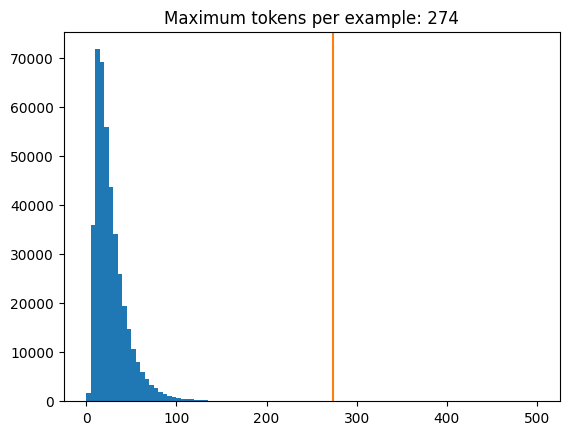

In [43]:
all_lengths = np.concatenate(lengths)
plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}')

Set up a data pipeline with The following function takes batches of text as input, and converts them to a format suitable for training. <br>1. It tokenizes them into ragged batches. <br>2. It trims each to be no longer than `MAX_TOKENS`. <br>3. It splits the target (English) tokens into inputs and labels. These are shifted by one step so that at each input location the `label` is the id of the next token. <br>4. It converts the `RaggedTensor`s to padded dense `Tensor`s. <br>5. It returns an `(inputs, labels)` pair.

In [44]:
MAX_TOKENS=128
def prepare_batch(ru, en):
    with tf.device('/cpu:0'):
        ru = tokenizers.ru.tokenize(ru) # Output is ragged.
        en = tokenizers.en.tokenize(en)
      
    ru = ru[:, :MAX_TOKENS] # Trim to MAX_TOKENS.
    ru = ru.to_tensor() # Convert to 0-padded dense Tensor
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor() # Drop the [END] tokens
    en_labels = en[:, 1:].to_tensor() # Drop the [START] tokens
    return (ru, en_inputs), en_labels

The function below converts a dataset of text examples into data of batches for training. <br>1. It tokenizes the text, and filters out the sequences that are too long. (The `batch`/`unbatch` is included because the tokenizer is much more efficient on large batches). <br>2. The `cache` method ensures that that work is only executed once. <br>3. Then `shuffle` and, `dense_to_ragged_batch` randomize the order and assemble batches of examples. <br>4. Finally `prefetch` runs the dataset in parallel with the model to ensure that data is available when needed. See [Better performance with the `tf.data`](https://www.tensorflow.org/guide/data_performance.ipynb) for details.

In [45]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [46]:
def make_batches(ds):
    return (ds.shuffle(BUFFER_SIZE)
            .batch(BATCH_SIZE)
            .map(prepare_batch, tf.data.AUTOTUNE)
            .prefetch(buffer_size=tf.data.AUTOTUNE))

In [47]:
# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [55]:
for (ru, en), en_labels in train_batches.take(1):
    break

print(ru.shape)
print(en.shape)
print(en_labels.shape)

(64, 113)
(64, 119)
(64, 119)


In [56]:
print(en[0][:10])
print(en_labels[0][:10])

tf.Tensor([   2   84 5089 2461  510  137  218 2813   97  126], shape=(10,), dtype=int64)
tf.Tensor([  84 5089 2461  510  137  218 2813   97  126   88], shape=(10,), dtype=int64)


In [57]:
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)

(2048, 512)


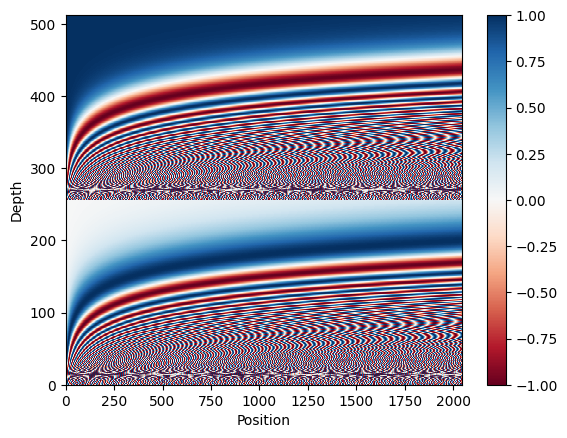

In [58]:
pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

(0.0, 1.0)

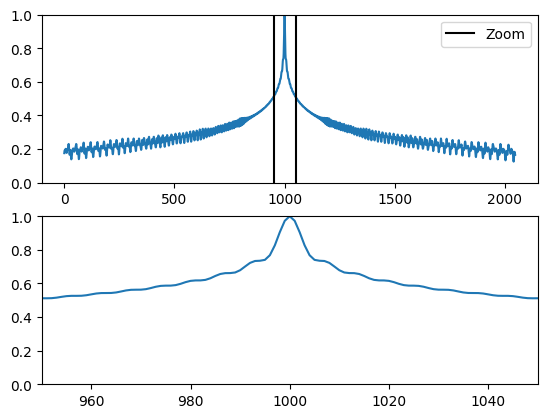

In [59]:
pos_encoding/=tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd,d -> p', pos_encoding, p)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])

In [60]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

In [61]:
embed_ru = PositionalEmbedding(vocab_size=tokenizers.ru.get_vocab_size(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size(), d_model=512)

ru_emb = embed_ru(ru)
en_emb = embed_en(en)

In [62]:
en_emb._keras_mask

<tf.Tensor: shape=(64, 119), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

In [63]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

In [64]:
class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True)

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

In [65]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(ru_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, ru_emb).shape)

(64, 113, 512)
(64, 119, 512)
(64, 119, 512)


In [66]:
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [67]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(ru_emb.shape)
print(sample_gsa(ru_emb).shape)

(64, 113, 512)
(64, 113, 512)


In [68]:
class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask = True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [69]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(en_emb.shape)
print(sample_csa(en_emb).shape)

(64, 119, 512)
(64, 119, 512)


In [70]:
out1 = sample_csa(embed_en(en[:, :3])) 
out2 = sample_csa(embed_en(en))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

4.7683716e-07

In [71]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),
          tf.keras.layers.Dense(d_model),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x

In [72]:
sample_ffn = FeedForward(512, 2048)

print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(64, 119, 512)
(64, 119, 512)


In [73]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

In [74]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(ru_emb.shape)
print(sample_encoder_layer(ru_emb).shape)

(64, 113, 512)
(64, 113, 512)


In [75]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(
            vocab_size=vocab_size, d_model=d_model)

        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        # `x` is token-IDs shape: (batch, seq_len)
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

        # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
          x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.

In [76]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8500)

sample_encoder_output = sample_encoder(ru, training=False)

# Print the shape.
print(ru.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 113)
(64, 113, 512)


In [77]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)

        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.cross_attention.last_attn_scores

        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        return x

In [79]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=ru_emb)

print(en_emb.shape)
print(ru_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(64, 119, 512)
(64, 113, 512)
(64, 119, 512)


In [81]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                                 d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(d_model=d_model, num_heads=num_heads,
                         dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)]

        self.last_attn_scores = None

    def call(self, x, context):
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x  = self.dec_layers[i](x, context)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        # The shape of x is (batch_size, target_seq_len, d_model).
        return x

In [82]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)

output = sample_decoder(
    x=en,
    context=ru_emb)

# Print the shapes.
print(en.shape)
print(ru_emb.shape)
print(output.shape)

(64, 119)
(64, 113, 512)
(64, 119, 512)


In [83]:
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=input_vocab_size,
                               dropout_rate=dropout_rate)

        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=target_vocab_size,
                               dropout_rate=dropout_rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        context, x  = inputs

        context = self.encoder(context)  # (batch_size, context_len, d_model)

        x = self.decoder(x, context)  # (batch_size, target_len, d_model)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
          # Drop the keras mask, so it doesn't scale the losses/metrics.
          # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass

        # Return the final output and the attention weights.
        return logits

In [84]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [86]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.ru.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

In [87]:
output = transformer((ru, en))

print(en.shape)
print(ru.shape)
print(output.shape)

(64, 119)
(64, 113)
(64, 119, 7796)


In [88]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 8, 119, 113)


In [89]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  3641344   
                                                                 
 decoder_1 (Decoder)         multiple                  5747712   
                                                                 
 dense_40 (Dense)            multiple                  1005684   
                                                                 
Total params: 10,394,740
Trainable params: 10,394,740
Non-trainable params: 0
_________________________________________________________________


In [90]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [91]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

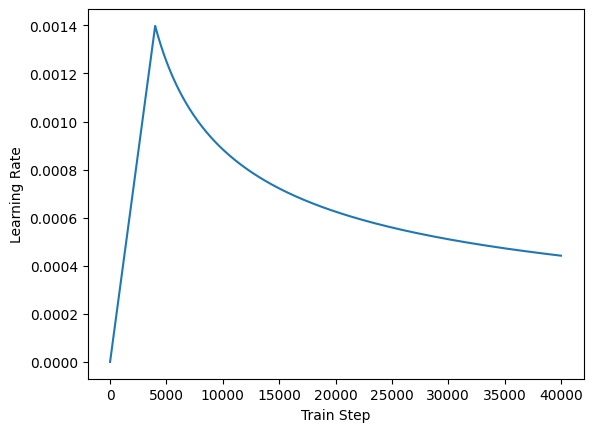

In [92]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [93]:
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [94]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [ ]:
with tf.device('/gpu:0'):
    transformer.fit(train_batches,
                    epochs=20,
                    validation_data=val_batches)

Epoch 1/20
 117/3252 [>.............................] - ETA: 7:59:43 - loss: 7.0178 - masked_accuracy: 0.0744

In [ ]:
class Translator(tf.Module):
    def __init__(self, tokenizers, transformer):
        self.tokenizers = tokenizers
        self.transformer = transformer

    def __call__(self, sentence, max_length=MAX_TOKENS):
        # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
        assert isinstance(sentence, tf.Tensor)
        if len(sentence.shape) == 0:
            sentence = sentence[tf.newaxis]

        sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

        encoder_input = sentence

        # As the output language is English, initialize the output with the
        # English `[START]` token.
        start_end = self.tokenizers.en.tokenize([''])[0]
        start = start_end[0][tf.newaxis]
        end = start_end[1][tf.newaxis]

        # `tf.TensorArray` is required here (instead of a Python list), so that the
        # dynamic-loop can be traced by `tf.function`.
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        output_array = output_array.write(0, start)

        for i in tf.range(max_length):
            output = tf.transpose(output_array.stack())
            predictions = self.transformer([encoder_input, output], training=False)

            # Select the last token from the `seq_len` dimension.
            predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

            predicted_id = tf.argmax(predictions, axis=-1)

            # Concatenate the `predicted_id` to the output which is given to the
            # decoder as its input.
            output_array = output_array.write(i+1, predicted_id[0])

            if predicted_id == end:
            break

        output = tf.transpose(output_array.stack())
        # The output shape is `(1, tokens)`.
        text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

        tokens = tokenizers.en.lookup(output)[0]

        # `tf.function` prevents us from using the attention_weights that were
        # calculated on the last iteration of the loop.
        # So, recalculate them outside the loop.
        self.transformer([encoder_input, output[:,:-1]], training=False)
        attention_weights = self.transformer.decoder.last_attn_scores

        return text, tokens, attention_weights

In [ ]:
translator = Translator(tokenizers, transformer)

In [ ]:
def print_translation(sentence, tokens, ground_truth):
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
    print(f'{"Ground truth":15s}: {ground_truth}')

In [ ]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

In [ ]:
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

In [ ]:
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

In [ ]:
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

In [ ]:
def plot_attention_head(in_tokens, translated_tokens, attention):
    # The model didn't generate `<START>` in the output. Skip it.
    translated_tokens = translated_tokens[1:]

    ax = plt.gca()
    ax.matshow(attention)
    ax.set_xticks(range(len(in_tokens)))
    ax.set_yticks(range(len(translated_tokens)))

    labels = [label.decode('utf-8') for label in in_tokens.numpy()]
    ax.set_xticklabels(
      labels, rotation=90)

    labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
    ax.set_yticklabels(labels)

In [ ]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

In [ ]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

In [ ]:
translated_tokens

In [ ]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [ ]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
    in_tokens = tf.convert_to_tensor([sentence])
    in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
    in_tokens = tokenizers.pt.lookup(in_tokens)[0]

    fig = plt.figure(figsize=(16, 8))

    for h, head in enumerate(attention_heads):
        ax = fig.add_subplot(2, 4, h+1)

        plot_attention_head(in_tokens, translated_tokens, head)

        ax.set_xlabel(f'Head {h+1}')

    plt.tight_layout()
    plt.show()

In [ ]:
plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights[0])

In [ ]:
sentence = 'Eu li sobre triceratops na enciclopédia.'
ground_truth = 'I read about triceratops in the encyclopedia.'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens, attention_weights[0])

In [ ]:
class ExportTranslator(tf.Module):
    def __init__(self, translator):
        self.translator = translator

    @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
    def __call__(self, sentence):
        (result,
         tokens,
         attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

        return result

In [ ]:
translator = ExportTranslator(translator)

In [ ]:
translator('este é o primeiro livro que eu fiz.').numpy()

In [ ]:
tf.saved_model.save(translator, export_dir='translator')

In [ ]:
reloaded = tf.saved_model.load('translator')

In [ ]:
reloaded('este é o primeiro livro que eu fiz.').numpy()